<a href="https://colab.research.google.com/github/frasertajima/kindle_clippings/blob/main/Kindle_my_clippings_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook ingests the `My Clippings.txt` file from the Kindle (located in the '/Documents' folder on your Kindle). You need to manually copy the file from your Kindle by connecting it to your PC and then uploading it to the Colab or local directory.  The result is a more useful database with:

+ `source` (the book, pdf or other source)
+ `reference` (the details of the highlight: page, location on Kindle, date of clipping)
+ `quote` (the actual text clipped on the Kindle)


You can, for example, display all quotes from a `source` or search `quote` for particular search terms, including using 'A or B' or 'A and B' search logic. Very basic machine learning is used to summarise topics found in the clippings and the dataframe is exported for more extensive processing on a separate notebook [`local_llm_processing.ipynb`](https://github.com/frasertajima/kindle_clippings/blob/main/local_llm_processing.ipynb).

The second part of the notebook automatically generates vocabulary words from single word highlights (when you highlight only one word in your Kindle). This permits an automatic collection of new vocabulary words (and, optionally, combination with an existing list of vocabulary words). A separate notebook, [`oxford dictionary lookup.ipynb`](https://github.com/frasertajima/kindle_clippings/blob/main/oxford_dictionary_lookup.ipynb) automatically looks up the definition of words using the Oxford dictionary API (which you will need to register for and obtain). While the API is free, there are limits to the number of words that can be looked up.

You will need the following files in the base directory:
- `My Clippings.txt`
- current vocabulary words in a csv file (you can import old vocabulary words here using a spreadsheet for example)
- `blank.csv` if a vocabulary file is not available

The vocabulary portion will save the new vocabulary words to `Kindle_vocab.csv`. It will then load up previously saved vocabulary words found in `Kindle_vocab_updated.csv`. If this Jupyter notebook has not been run before, the `Kindle_vocab_updated.csv` file will not exist and the notebook will look for a base vocabulary file (`2DoList.csv`) failing which it will load up a blank.csv file. If you wish to add your existing vocabulary words with definitions, save them to a csv file format using a spreadsheet and save them as `2DoList.csv` (or modify the base vocabulary file name accordingly in the notebook).

---

This update reflects the changes made to the previously fixed file structure that Amazon was using for the Kindle Paperwhite (the Paperwhite now follows the Scribe with irregular line lengths so `quote` could be 2 or 3 lines long for example). The updated Kindle file structures also mean that the Kindle Scribe and Paperwhite are now both supported by the same notebook now that the Paperwhite file structure has been updated to match the Scribe's (just rename the "My clipping.txt" file for each device).

-Pandas 2.2 required for pyarrow support

-pyarrow conversion now enables pyarrow string instead of old numpy object. Need to convert `unique_sources` to pyarrow array first before using .sort() for PyArrow String.

- added one line CPU numba acceleration with @jit for functions

-py310 conda env

In [1]:
#%load_ext cudf.pandas      # slowing down concat
import pandas as pd         # need pandas 2.2 for pyarrow support in .read_table()
#import cupy as np          # colab requires an install so use numpy instead
import numpy as np
import warnings
import pyarrow as pa

# add numa jit (CPU):
from numba import jit

# for Paperwhite:
#kindle_clipping_file="My Clippings.txt"

# for Scribe:
kindle_clipping_file="My Clippings Scribe.txt"

# enable pyarrow
pd.options.mode.string_storage = "pyarrow"

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 3000
pd.set_option('display.max_rows', 40)

# Enable CoW
pd.options.mode.copy_on_write = True

# read table using pyarrow engine and dtype backend
data = pd.read_table(kindle_clipping_file, 
                     header=None, 
                     names=['column_1'], 
                     engine="pyarrow", 
                     dtype_backend="pyarrow"
                     )

data

,column_1
0,"As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)"
1,"- Your Highlight on Location 12-12 | Added on Thursday, August 17, 2023 12:13:47 PM"
2,reached 2.1 million
3,==========
4,These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)
...,...
12179,==========
12180,White House Whacks Fox; Paramount's Mixed Bag; Remembering Richard (Unknown)
12181,"- Your Highlight on page 3 | Location 28-32 | Added on Thursday, February 29, 2024 3:51:44 PM"
12182,"And while Fox News' roster of unscrupulous right-wing hosts have declined to properly correct the record, the outlet's supposedly nonpartisan news website has also failed to update its ""EXCLUSIVE"" reporting from last summer publicly surfacing the informant’s false claims. Articles by reporter Brooke Singman advancing Smirnov’s bribery allegations remain unaltered on the Fox News website without a correction or mention that Smirnov has been charged with lying to the federal law enforcement about the very claims she reported."


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12184 entries, 0 to 12183
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   column_1  12184 non-null  string[pyarrow]
dtypes: string[pyarrow](1)
memory usage: 1.3 MB


In [3]:
# paperwhite file structure has changed like with the Scribe
# this old fixed length method no longer works (see next cell for replacement)
# extract source, highlight_detail and quote from dataframe
#source=data.iloc[::4, :]
#highlight_detail=data.iloc[1::4, :]
#quote=data.iloc[2::4, :]

In [4]:
# ai suggestion modified:

# added @jit for numba CPU acceleration with one line
@jit
def categorize_dataframe(df):

    # Initialize empty df to store the values
    source = pd.DataFrame({
        'source': [""]
    })

    reference = pd.DataFrame({
        'reference': [""]
    })

    quote = pd.DataFrame({
        'quote': ['']
    })

    # Initialize a counter
    counter = 0
    quote_count = 0
    holder = ""

    # go through dataframe to extract source, reference and quote
    for value in data['column_1']:

        # deal with empty quote line
        if counter == 2:
            if value == '==========':

                new_row = pd.DataFrame({
                    'quote': [""]
                })
                # polars:
                #quote = quote.vstack(new_row)
                # pandas:
                quote = pd.concat([quote, new_row], ignore_index=True)


        #######################################################
        # normal operations:

        if counter == 0:
            new_row = pd.DataFrame({
                'source': [value]
            })
            new_row['source'] = new_row['source'].astype('string[pyarrow]')
            #source = source.vstack(new_row)
            source = pd.concat([source, new_row], ignore_index=True)
            counter += 1

        elif counter == 1:
            new_row = pd.DataFrame({
                'reference': [value]
            })
            new_row['reference'] = new_row['reference'].astype('string[pyarrow]')
            #reference = reference.vstack(new_row)
            reference = pd.concat([reference, new_row], ignore_index=True)
            counter += 1

        else:
            # for quote, need to handle multi line quotes, combine them to one line
            # otherwise they cannot be joined with other columns

            if not (value == '=========='):
                quote_count +=1
                # combine strings to holder
                # needed str(holder) + str(value) instead of holder + str
                # because rapids threw up error about empty str
                # but no error on py310 conda env!
                holder = str(holder) + str(value)
                # print(holder, quote_count)
                list_holder = holder[:]
                new_row = pd.DataFrame({
                    'quote': [list_holder]
                })

                new_row['quote'] = new_row['quote'].astype('string[pyarrow]')

                # update quote normally if quote_count is not > 1:
                if quote_count == 1:
                    #quote = quote.vstack(new_row)
                    quote = pd.concat([quote, new_row], ignore_index=True)

                # if multiline and quote_count > 1: slice off last row before updating
                elif quote_count > 1:
                    # print(list_holder, quote_count)
                    # update previous row to avoid duplication
                    quote = quote[:-1]
                    #quote = quote.vstack(new_row)
                    quote = pd.concat([quote, new_row], ignore_index=True)
                counter += 1


            else:   # hit delimiter '==========='
                quote_count = 0
                #counter += 1

        ################################################
        if value == '==========':
            counter = 0
            holder = ""
            continue


    # combine source, reference, quote into new_df
    #new_df = source[1:].hstack(reference[1:])
    #new_df = new_df.hstack(quote[1:])
    new_df = pd.concat([source.iloc[1:], reference.iloc[1:]], axis=1)
    new_df = pd.concat([new_df, quote.iloc[1:]], axis=1)
    return new_df

df = categorize_dataframe(data)
df[-50:]

,source,reference,quote
2993,news2,"- Your Highlight on page 1 | Location 7-8 | Added on Wednesday, February 28, 2024 2:39:57 PM","The case, centered on a stalled resort development worth tens of millions of dollars, speaks to widespread frustration in China with how authorities are managing the world’s second-largest economy, with previously profligate local governments now struggling to pay their debts"
2994,news2,"- Your Highlight on page 1 | Location 9-11 | Added on Wednesday, February 28, 2024 2:40:10 PM","The controversy erupted this week after a state-run newspaper published a report late Sunday saying that Ma Yijiayi, a construction contractor, spent years waging legal battles to press claims against officials in Shuicheng, a district of Guizhou province, only for local authorities to take her and her lawyers into custody late last year for allegedly disrupting public order."
2995,news2,"- Your Highlight on page 2 | Location 16-18 | Added on Wednesday, February 28, 2024 2:40:31 PM","“Now they don’t even bother to pretend, they are committing daylight robbery,” one commentator wrote in an essay that garnered more than 100,000 views on the WeChat social-media app. “Using power to suppress the law and grasping power to play tricks, deadbeats with power are the deadliest.”"
2996,news2,"- Your Highlight on page 3 | Location 34-36 | Added on Wednesday, February 28, 2024 2:41:54 PM","Debt woes are particularly acute in Guizhou , one of China’s poorest provinces, where authorities borrowed heavily to fund spending on bridges and highways, as well as rural-development projects that underpin Chinese leader Xi Jinping’s campaign to eradicate extreme poverty."
2997,news2,"- Your Highlight on page 4 | Location 42-44 | Added on Wednesday, February 28, 2024 2:42:27 PM","According to China Business Journal, Shuicheng officials offered Ma in November a lump-sum payment of 12 million yuan to settle the dispute despite owing about 220 million yuan in project payments. Ma rejected the offer, and soon after, local police detained her and her lawyers, the newspaper said."
...,...,...,...
3038,"Market herding is everywhere, not just the US (Unknown)","- Your Highlight on page 4 | Location 26-29 | Added on Thursday, February 29, 2024 3:48:09 PM","Since the American market eclipsed the UK more than a century ago, the US has been the biggest on earth, save a couple of years at the peak of the Japanese bubble in 1989 and 1990. It now accounts for 61% of global market cap, its highest since the 1960s, when China and Russia had no stock market. Stocks are indeed unusually concentrated globally — but avoiding this has also meant missing out on years of great US performance. Is concentration necessarily bad?"
3039,news2,"- Your Highlight on page 1 | Location 6-8 | Added on Thursday, February 29, 2024 3:49:47 PM","A California state judge tentatively ruled that nearly 6,000 Black factory workers can sue Tesla TSLA as a group for the electric vehicle maker's alleged failure to address rampant race discrimination and harassment at its Fremont plant."
3040,White House Whacks Fox; Paramount's Mixed Bag; Remembering Richard (Unknown),"- Your Highlight on page 3 | Location 22-25 | Added on Thursday, February 29, 2024 3:50:58 PM","when the FBI informant, Alexander Smirnov, was charged earlier this month with fabricating the bribery allegations against Biden, even apparently confessing that Russian intelligence was involved in seeding the smear, Fox News refused to walk back the story in a meaningful way."
3041,White House Whacks Fox; Paramount's Mixed Bag; Remembering Richard (Unknown),"- Your Highlight on page 3 | Location 25-28 | Added on Thursday, February 29, 2024 3:51:26 PM","Hannity, the network's top promoter of the corruption claims, stuck by the narrative that he had promoted in dozens of segments (though he did disclose to viewers that the informant had been charged, spinning the development to attack the media). Elsewhere on the network, Watters 

In [5]:
# finally was able to force object to pyarrow string:

df = df.convert_dtypes(
    convert_boolean=False,
    convert_floating=False,
    convert_integer=False,
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 1 to 3042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     3042 non-null   string
 1   reference  3042 non-null   string
 2   quote      3042 non-null   string
dtypes: string(3)
memory usage: 1.3 MB


In [6]:
df['source']

1                                 As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)
2       These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)
3       These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)
4       These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)
5       These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)
                                                                               ...                                                                         
3038                                                            

# sources sorted

In [7]:
# output all the sources used in Kindle clippings
unique_sources = df['source'].unique()
unique_sources

# to sort pandas <ArrowStringArray>, convert to pyarrow array and use .sort()
# convert the pyarrow array back to pandas to display/print
sorted_array = pa.array(unique_sources).sort()
sorted_array.to_pandas()

0                                                                                   2023-ariya (Fraser Tajima)
1                                                                           978-1-4842-9691-2 (James Reinders)
2                     A 30-Year Trap The Problem With America’s Weird Mortgages - The New York Times (Unknown)
3      Accelerating Vector Search_ Fine&amp;#x2d;Tuning GPU Index Algorithms _ NVIDIA Technical Blog (nvda.ws)
4                   Adani family's partners used 'opaque' funds to invest in its stocks - media group (Amazon)
                                                        ...                                                   
243                                                the-wall-street-journal 30-09-2023 (Kobo) (NewspaperDirect)
244                                                the-wall-street-journal 30-10-2023 (Nook) (NewspaperDirect)
245                                                            the-week-us 17-11-2023 (Kobo) (NewspaperDirect)
2

# Machine learning dataset

In [8]:
# save df to file for machine learning by other notebooks
# use 'kindle_scribe_new_df.csv' in a separate notebook for machine learning text processing
df.to_csv('kindle_scribe_new_df.csv', index=False)

# Set search parameters here

With this Kindle clipping database, you can now define `search_term` and `search_term2`. For example, if you only want to search within Shakespeare books, you can enter 'shakespeare' as `search_term`. Leaving a search term blank searches all instances or sources. You can also be very specific, such as `'tesla | China'` to search for 'tesla' or 'China' in the clipping. If you want both, use `'tesla .* China'`.

In [21]:
pd.set_option('display.max_rows', None)
search_term = ''                      # leave blank to search all sources
search_term2 = 'NVDA | Nvidia'                        # use | for or, .* for and
df_search = df[df['source'].str.contains(search_term, case=False, na=False)]
df_search = df_search[df_search['quote'].str.contains(search_term2, case=False, na=False)]
df_search[['source','quote','reference']]

,source,quote,reference
158,"Genius Makers: The Mavericks Who Brought AI to Google, Facebook, and the World (Cade Metz)","Spurred by the $130 million in graphics chips it sold to Google, Nvidia reorganized itself around the deep learning idea, and soon it was not merely selling chips for AI research, it was doing its own research, exploring the boundaries of image recognition and self-driving cars, hoping to expand the market even further.","- Your Highlight on page 141 | Location 2151-2153 | Added on Friday, August 18, 2023 9:18:02 AM"
266,The New York Times (calibre),"The scarcity has created a stark contrast between the haves and have-nots. In June, Inflection AI , an A.I. start-up in Palo Alto, Calif., announced it had acquired 22,000 of Nvidia’s H100 chips. It also said it raised $1.3 billion from Microsoft, Nvidia and others. Mustafa Suleyman, Inflection’s chief executive, said in an interview that the company planned to spend at least 95 percent of the funds on GPUs. “It’s a seismic amount of compute,” he said. “It’s just eye-watering.” Other start-ups have asked him to share, he said, but the company is already at full capacity.","- Your Highlight on page 60 | Location 918-923 | Added on Saturday, August 19, 2023 9:11:56 AM"
320,the-wall-street-journal 22-08-2023 (Sony) (NewspaperDirect),"Chief among those was Nvidia, the chip making giant that will report earnings on Wednesday. Its shares rose 8.5%, putting their year-to-date gain at 221% and fully erasing their month-to-date losses. Also bouncing back from tough weeks were Tesla, which jumped 7.3% and Meta Platforms, which rose 2.3%.","- Your Highlight on Location 3404-3406 | Added on Tuesday, August 22, 2023 11:09:49 AM"
321,The New York Times - calibre (calibre),"In May, the company’s status as the most visible winner of the A.I. revolution became clear when it projected a 64 percent leap in quarterly revenue, far more than Wall Street had expected. On Wednesday, Nvidia — which has surged past $1 trillion in market capitalization to become the world’s most valuable chip maker — is expected to confirm those record results and provide more signals about booming A.I. demand.","- Your Highlight on Location 1361-1365 | Added on Tuesday, August 22, 2023 11:17:38 AM"
324,The New York Times - calibre (calibre),"Nvidia has also directed cash and scarce H100s lately to upstart cloud services such as CoreWeave, which allow companies to rent time on computers rather than buying their own. CoreWeave, which will operate Inflection’s hardware and owns more than 45,000 Nvidia chips, raised $2.3 billion in debt this month to help buy more.","- Your Highlight on Location 1405-1407 | Added on Tuesday, August 22, 2023 11:19:38 AM"
348,the-wall-street-journal 24-08-2023 (Sony) (NewspaperDirect),"This year, Nvidia’s stock has more than tripled, and investors in the options markets had been betting heavily that the shares would rise further after Wednesday’s results.","- Your Highlight on Location 221-222 | Added on Thursday, August 24, 2023 9:45:51 AM"
380,The New York Times (calibre),"Chip sales for data centers, where most A.I. training is accomplished, are now the company’s biggest business. Revenue from that business grew 171 percent to $10.3 billion in the second period, Nvidia said","- Your Highlight on page 79 | Location 1200-1201 | Added on Thursday, August 24, 2023 1:26:40 PM"
392,the-wall-street-journal 26-08-2023 (Sony) (NewspaperDirect),"It raised more than $400 million this spring from chip maker Nvidia and other investors. It secured another $2.3 billion in debt financing this summer to open data centers by essentially turning chips into financial instruments, using its stash of highly coveted Nvidia semiconductors as collateral. Now it’s racing to keep pace with the fastest software-adoption curve in history.","- Your Highlight on Location 2952-2954 | Added on Saturday, August 26, 2023 9:58:51 PM"
485,the-economist 26-08-2023 (Sony) (NewspaperDirect),"Arm published a pros

In [22]:
# Save the dataframe to an HTML file
df_html = df_search[['source','quote','reference']]
df_html.to_html('search_results.html')

In [10]:
# used a dataset visualisation example code to display the length of the highlight column
# there is an elegant pure polars version suggested by Alexander Beedie which is superior
# but polars is having some instability with .unique() so this long version is used for now

"""Module to explore data.
Contains functions to help study, visualize and understand datasets.
https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

@jit
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

@jit
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

@jit
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

@jit
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


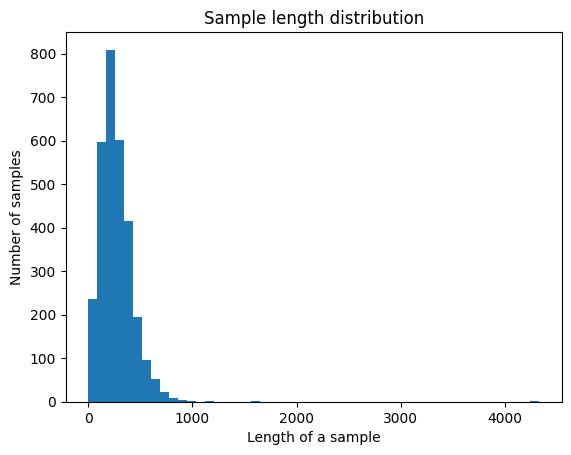

In [11]:
plot_sample_length_distribution(df['quote'])

# Topic generator
Simple code sample from Bing AI to get an overview of the topics covered in the Kindle clippings.

In [12]:
# modified sample code from Bing AI to get some overview of the topics
# covered in the Kindle clipping dataset; once you have topics, you can
# conduct boolean searches as shown previously for more detail

# Import the necessary modules
# from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Extract the document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                             max_features=1000,
                             stop_words='english')
X = vectorizer.fit_transform(df['quote'])

# Fit the LDA model with n_components topics
lda = LatentDirichletAllocation(n_components=10, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X)

# Print the top 10 words for each topic
# feature_names = vectorizer.get_feature_names() bug requires _out() until updated
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-11:-1]]))
    print()

Topic #0:
ai intel data chips hydrogen power energy network years technology

Topic #1:
said time like just don going make says people long

Topic #2:
new money company said companies research intelligence investors private ai

Topic #3:
state practice turn owned powerful house improve skills highly california

Topic #4:
musk said mr trump tesla company media platform social elon

Topic #5:
market stock rates higher investors stocks times tech high earnings

Topic #6:
year billion according cent 000 million company month percent shares

Topic #7:
china chinese said country economy government property economic companies debt

Topic #8:
states new united ai like silver world people law data

Topic #9:
year tesla sales quarter electric vehicles china market ev cars



# Vocabulary generator

Another potentially useful feature is generating vocabulary automatically from the Kindle clippings. The code takes all single word clippings and adds them to the 'Kindle_vocab.csv' file.

In [13]:
vocabulary = df['quote'].str.strip().str.split(' ').str.len().eq(1)
output = df[vocabulary]
vocab = output.loc[:,('quote')].str.rstrip('.,;?')
df_csv = vocab.to_csv('Kindle_vocab.csv', index=True)
print('Printed to Kindle_vocab.csv')

Printed to Kindle_vocab.csv


In [14]:
vocab[0:10]

32                    Scam
52                  fervid
190                   Good
241                       
242                       
269             Pointless 
300                .split(
479    torch.cuda.Stream()
501              Aegyptius
883                       
Name: quote, dtype: string

In [15]:
# loads updated vocabulary file first. If this is the first time because Kindle clips have not been added
# or the file is missing then load base vocabulary file from 2DoList.csv
# if that file is missing, load blank.csv

try:
    main_vocabulary = pd.read_csv("Kindle_vocab_updated.csv")
except Exception as e:
    print("Kindle_vocab_updated.csv file not found, loading base file.")
    try:
        main_vocabulary = pd.read_csv("2DoList.csv")     # csv vocabulary file created previously
    except Exception as e:
        main_vocabulary = pd.read_csv("blank.csv")       # empty csv file if no vocabulary files available
main_vocabulary.shape

(890, 2)

In [16]:
# make sure index is the same
vocab.index = np.arange(0, len(vocab) + 0)

# object to dataframe
vocab_add = pd.DataFrame(vocab)

# create same column name
vocab_add.columns = ['WORD']

In [17]:
# filter for empty entries:
vocab_add = vocab_add[vocab_add['WORD'] != ""]
#vocab_add = vocab_add.filter(pl.col('WORD') != "")   #polars version
vocab_add

,WORD
0,Scam
1,fervid
2,Good
5,Pointless
6,.split(
7,torch.cuda.Stream()
8,Aegyptius
10,hyperpathetic
11,appositions—
12,parataxes


In [18]:
# update with new words only
# https://stackoverflow.com/questions/52342627/appending-only-new-values-from-a-dataframe-to-another-dataframe-in-pandas

updated_vocabulary = vocab_add.merge(main_vocabulary, how='left', indicator=True)
# selecting rows that are flagged with left_only
updated_vocabulary = updated_vocabulary[updated_vocabulary._merge == 'left_only'].iloc[:,:-1]
# update main_vocabulary with only updated words
main_vocabulary = pd.concat([main_vocabulary, updated_vocabulary], ignore_index=True)

display(main_vocabulary.shape)     #  checked that it does not add duplicate rows or columns even when repeated

# save to csv
df_csv = main_vocabulary.to_csv('Kindle_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns
print('Saved new Kindle clipping words to Kindle_vocab_updated.csv.')

(895, 2)

Saved new Kindle clipping words to Kindle_vocab_updated.csv.


In [19]:
test_vocabulary = pd.read_csv("Kindle_vocab_updated.csv")
test_vocabulary.shape
test_vocabulary[0:10]

,WORD,NOTE
0,abaddon,a name for the Devil (Rev. 9:11) or for hell.
1,abaft,in or behind the stern of a ship
2,abba,(in the New Testament) God as father
3,aberglaube,Belief in things beyond the certain and verifiable.
4,abet,"encourage or assist (someone) to do something wrong, in particular to commit a crime"
5,abeyance,a state of temporary disuse or suspension
6,abidden,NaN
7,abigail,a lady's maid.
8,abiogenesis,the original evolution of life or living organisms from inorganic or inanimate substances
9,ablactation,Originally: the weaning of a child or other young mammal. In later use also: suppression or cessation of lactation.
